In [22]:
%matplotlib inline
import math
import numpy as np

from scipy import integrate
from scipy import interpolate
from scipy.integrate import odeint

import matplotlib.pyplot as plt

from nbodykit.lab import *

In [23]:
cosmo = cosmology.Planck15

In [24]:
Omega_m = cosmo.Omega_m(0)
Omega_L = cosmo.Omega_lambda(0)
tau_array = [0.005,0.005,-0.01]
a_begin = 1/(1+200)
a_end = 1
points = 3000

def Hubble(a):
    matter = Omega_m/a**3
    Lambda = Omega_L
    return np.sqrt(matter+Lambda)

def dHda(a):
    up = -3*Omega_m
    down = 2*a**4*Hubble(a)
    return up/down

def dHdloga(a):
    return a*dHda(a)

def growth_int(a):
    return 1./(a*Hubble(a))**3

def growth_D(a):
    factor = 5*Omega_m*Hubble(a)/2
    return factor*integrate.quad(growth_int, 0, a)[0]

def dDda(a):
    factor = 5*Omega_m*dHda(a)/2
    second = 5*Omega_m/(2*a**3*Hubble(a)**2)
    return factor*integrate.quad(growth_int, 0, a)[0] + second

def dDdloga(a):
    return a*dDda(a)

vgrowth_D = np.vectorize(growth_D)
vdDda = np.vectorize(dDda)
vdDdloga = np.vectorize(dDdloga)

In [25]:
a_array = np.logspace(np.log(a_begin), np.log(1), points, base=np.exp(1))
lna_array = np.log(a_array)
a_da = np.zeros((points,2,3))

def Delta_f(x, lna, tau):
    a = np.exp(lna)
    first = 2+dHdloga(a)/Hubble(a) 
    timetau = tau*vgrowth_D(a)/vgrowth_D(1)
    const = 3*Omega_m*timetau/(2*a**3*Hubble(a)**2)
    ret = [
        x[1],
        -first*x[1] -const*(1+x[0]) 
    ]
    return ret

inifac = growth_D(a_array[0])/growth_D(1)
dinifac = inifac*vdDdloga(a_array[0])/growth_D(a_array[0])

inifac_array = -np.array([inifac, dinifac])

Delta_ini = np.array([tau_array[0]*inifac_array,
                      tau_array[1]*inifac_array,
                      tau_array[2]*inifac_array])

for i in range(3):
    a_da[:,:,i] = odeint(Delta_f, Delta_ini[i], lna_array, args=(tau_array[i],))

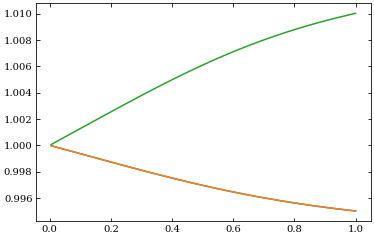

In [26]:
plt.plot(a_array,1+a_da[:,0,0])
plt.plot(a_array,1+a_da[:,0,1])
plt.plot(a_array,1+a_da[:,0,2])

In [27]:
ai_save = np.zeros((points,4))
ai_save[:,0] = a_array
ai_save[:,1:4] = a_da[:,0,:]
np.savetxt('Aniss_planck15_p0005p0095m001_z200',ai_save)
print(ai_save)

[[ 4.97512438e-03 -3.17175339e-05 -3.17175339e-05  6.34350678e-05]
 [ 4.98392996e-03 -3.17736850e-05 -3.17736850e-05  6.35473699e-05]
 [ 4.99275113e-03 -3.18299270e-05 -3.18299270e-05  6.36598518e-05]
 ...
 [ 9.96469531e-01 -4.98333804e-03 -4.98333804e-03  1.00118202e-02]
 [ 9.98233205e-01 -4.98794140e-03 -4.98794140e-03  1.00211119e-02]
 [ 1.00000000e+00 -4.99253951e-03 -4.99253951e-03  1.00303931e-02]]
